In [1]:
import re
import string
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import flatten
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [2]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.add('lol')
stop_words.remove("not")
stop_words.remove("no")

# Data Preparation

In [3]:
df = pd.read_csv("/Users/austinyu/Downloads/Working From Home.csv")
df = df.fillna(' ')
df.head(2)

,Timestamp,What is your current occupation?,"In your position in the office, did you find yourself having idle chit chat with people in your department?","If so, do you find that you miss it now that you've gone online?",How important is networking to you/your career?,Did you ever attend in-person networking sessions for your industry?,How are you currently approaching networking?,Do you feel that this limit of face to face networking will impact your career?,How long have you been working from home (answer in days?),Tell us about your work from home experience.,What do you like most about working from home?,What do you like the least about working from home?,Which social media apps do you use for professional networking?,"When things go back to normal, would you want to continue working from home?",Which social media apps do you use?
0,2020/04/27 6:07:37 PM MDT,Compositor,Yes,Somewhat,4,Yes,Am not,A little,45,Lonely,"Can take naps during lunch, don't have to pay ...",Difficult to get feedback from supervisors\n A...,Linkedln,Yes,Instagram;Facebook
1,2020/04/27 6:25:30 PM MDT,self-employ,Maybe,not really,4,No,so far so good,yes,45,never work from home before,easy to control my own time,hard to cooperate with other people's time,Other,Maybe,Instagram;Other


# EDA

### Job Title

In [4]:
df['What is your current occupation?'] = df['What is your current occupation?'].apply( lambda x: x.lower())
df['What is your current occupation?'] = df['What is your current occupation?'].apply( lambda x: " ".join(x.split()))
df['What is your current occupation?'] = df['What is your current occupation?'].apply( lambda x: " ".join([w for w in x.split() if w not in stop_words]))
df['What is your current occupation?'] = df['What is your current occupation?'].apply(lambda x: " ".join([w for w in x.split() if len(w)>1]))
df['What is your current occupation?'].head();

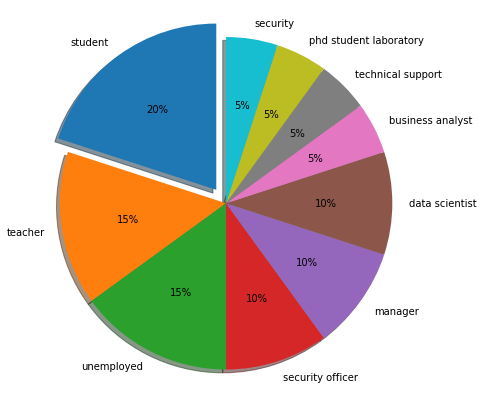

In [5]:
labels = df['What is your current occupation?'].value_counts()[0:10].index
sizes = df['What is your current occupation?'].value_counts()[0:10].values
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)  

plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90)
plt.axis('equal') 

plt.show()

### How important is networking to you/your career?

Text(0, 0.5, 'Rating')

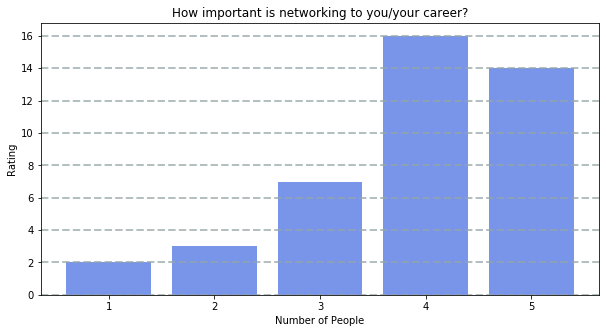

In [6]:
plt.figure(figsize = (10,5))

plt.bar(df['How important is networking to you/your career?'].value_counts().index, 
        df['How important is networking to you/your career?'].value_counts().values,color='royalblue',alpha=0.7);
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.title('How important is networking to you/your career?');
plt.xlabel('Number of People')
plt.ylabel('Rating')

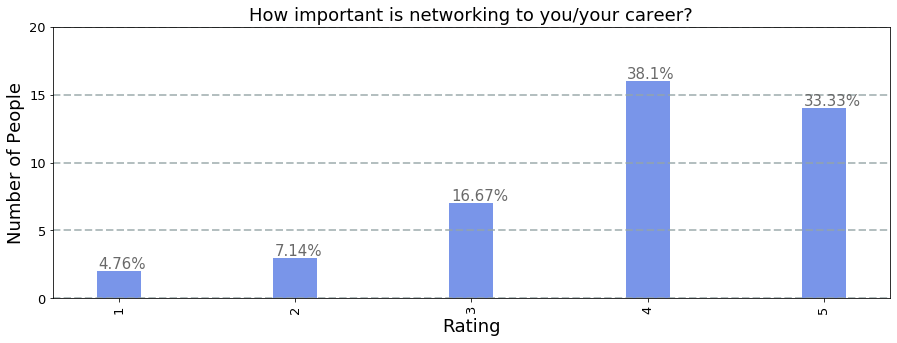

In [8]:
ax = df['How important is networking to you/your career?'].value_counts().sort_values().sort_index().plot(kind='bar', figsize=(15,5),
                                        color='royalblue',alpha=0.7, fontsize=13,width = 0.25);
ax.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
ax.set_alpha(0.8)
ax.set_title('How important is networking to you/your career?', fontsize=18)
ax.set_ylabel('Number of People', fontsize=18);
ax.set_xlabel('Rating', fontsize=18);
ax.set_yticks([0, 5, 10, 15, 20])

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+0.01, i.get_height()+0.2, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

# NLP

### Build Function

In [9]:
def lemmatization(x):
    texts = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-':
            lemma = token.text
        texts.append(lemma)
        
    return(" ".join(texts))

In [10]:
def clean_feature(feature):
    
    feature = feature.apply( lambda x: x.lower())
    feature = feature.apply( lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x))
    feature = feature.apply( lambda x: re.sub(r'\d', '', x))
    feature = feature.apply( lambda x: " ".join(x.split()))
    #feature = feature.apply( lambda x: lemmatization(x))
    feature = feature.apply( lambda x: " ".join([w for w in x.split() if w not in stop_words]))
    feature = feature.apply( lambda x: " ".join([w for w in x.split() if len(w)>1]))
    
    return feature

In [11]:
def plot_info(feature):
    
    type_text = [text for text in feature]
    type_text = ' '.join(type_text).split()
    count_text = Counter(type_text)
    top_text = count_text.most_common(20)
    text_words = [word[0] for word in top_text]
    text_counts = [word[1] for word in top_text]
    text_reshape = ' '.join([word[0] for word in count_text.most_common(200)])

    wordcloud = WordCloud(width=800, height=800,background_color="white",
                     max_font_size=200).generate(text_reshape)
    
    return wordcloud,text_words,text_counts

### Relabel

In [12]:
df['like'] = df['What do you like most about working from home?']
df['unlike'] = df['What do you like the least about working from home?']
df['wfh'] = df['Tell us about your work from home experience.']
df['job'] = df['What is your current occupation?']

### Clean Text

In [13]:
df['like'] = clean_feature(df['like'])
df['unlike'] = clean_feature(df['unlike'])
df['wfh'] = clean_feature(df['wfh'])
df['job'] = clean_feature(df['job'])

### Plot Set Up

In [14]:
like_wordcloud, like_words, like_counts = plot_info(df['like'])
unlike_wordcloud, unlike_words, unlike_counts = plot_info(df['unlike'])
job_wordcloud, job_words, job_counts = plot_info(df['job'])
wfh_wordcloud, wfh_words, wfh_counts = plot_info(df['wfh'])

### Like the Most about Working From Home Plot

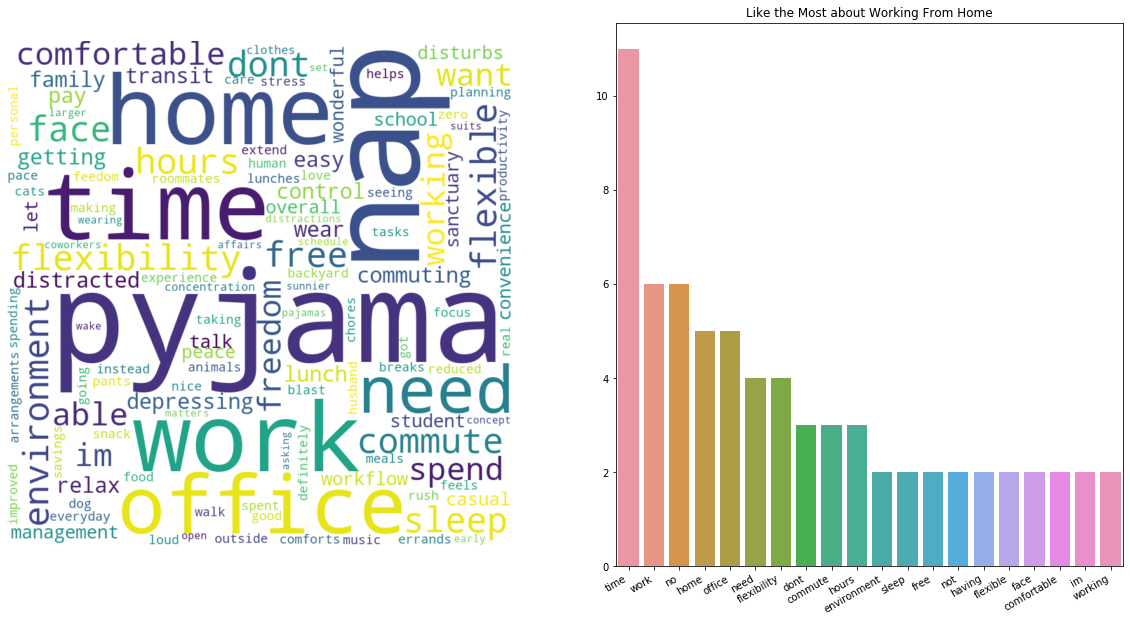

In [26]:
fig, ax = plt.subplots(1,2,figsize= (20,10))

ax[0].imshow(like_wordcloud, interpolation="bilinear")
ax[0].axis('off')

ax[1] = sns.barplot(x=like_words, y=like_counts)
ax[1].set_title('Like the Most about Working From Home')
plt.xticks(rotation=30, ha='right')


plt.show()

### Like the Least about Working From Home Plot

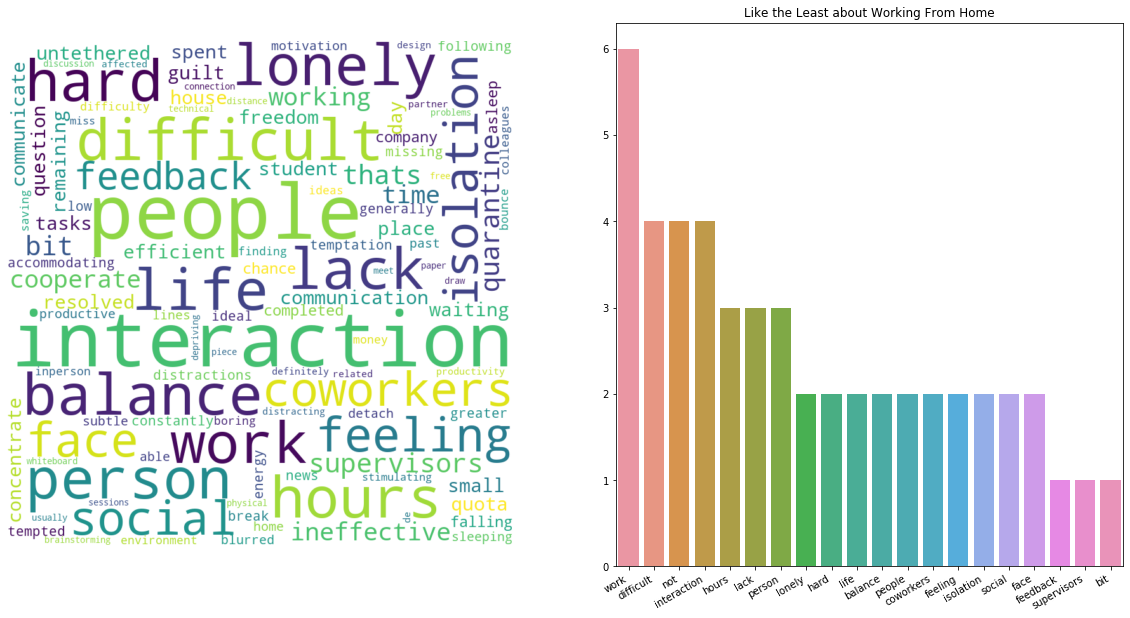

In [27]:
fig, ax = plt.subplots(1,2,figsize= (20,10))

ax[0].imshow(unlike_wordcloud, interpolation="bilinear")
ax[0].axis('off')


ax[1] = sns.barplot(x=unlike_words, y=unlike_counts)
ax[1].set_title('Like the Least about Working From Home')
plt.xticks(rotation=30, ha='right')


plt.show()

### Work From Home Experience Plot

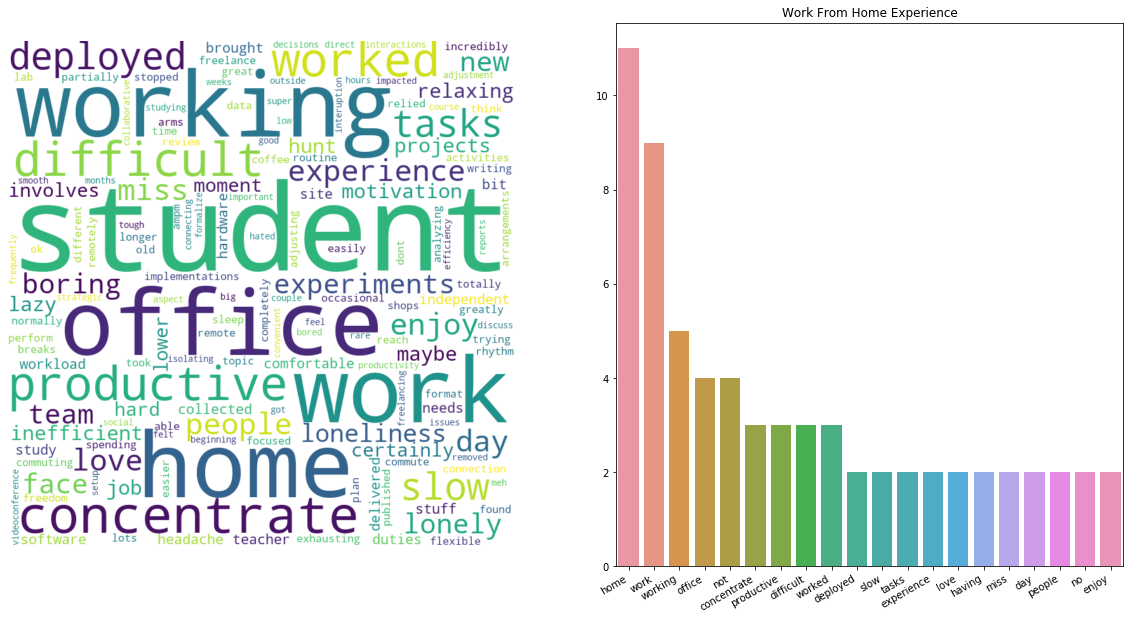

In [28]:
fig, ax = plt.subplots(1,2,figsize= (20,10))

ax[0].imshow(wfh_wordcloud, interpolation="bilinear")
ax[0].axis('off')

ax[1] = sns.barplot(x=wfh_words, y=wfh_counts)
ax[1].set_title('Work From Home Experience')
plt.xticks(rotation=30, ha='right')

plt.show()

# Create Name

In [29]:
#Copy the code during to time limit
#Credits: From the link below
#http://andrewjmoodie.com/2018/03/python-3-silly-random-name-generator/

import urllib.request
import random

word_url = "http://svnweb.freebsd.org/csrg/share/dict/words?view=co&content-type=text/plain"
response = urllib.request.urlopen(word_url)
long_txt = response.read().decode()
words = long_txt.splitlines()

upper_words = [word for word in words if word[0].isupper()]
name_words  = [word for word in upper_words if not word.isupper()]
one_name = ' '.join([name_words[random.randint(0, len(name_words))] for i in range(2)])


def rand_name():
    name = ' '.join([name_words[random.randint(0, len(name_words))] for i in range(2)])
    return name

naming = []
for n in range(df.shape[0]):
    if n == 17:
        naming.append("Austin")
    elif n == 29:
        naming.append("Bibi")
    else:
        name = rand_name()
        naming.append(name)

In [30]:
df['name'] = pd.DataFrame(naming)

# Recommendation Engine

In [31]:
df['Which social media apps do you use for professional networking?'] = df['Which social media apps do you use for professional networking?'].apply( lambda x: x.lower())
df['Which social media apps do you use for professional networking?'] = df['Which social media apps do you use for professional networking?'].apply( lambda x: " ".join(x.split()))
df['Which social media apps do you use for professional networking?'] = df['Which social media apps do you use for professional networking?'].apply( lambda x: " ".join([w for w in x.split() if w not in stop_words]))
df['Which social media apps do you use for professional networking?'] = df['Which social media apps do you use for professional networking?'].apply(lambda x: " ".join([w for w in x.split() if len(w)>1]))
df['social_apps'] = df['Which social media apps do you use for professional networking?']

In [32]:
def combine_text(row):
    return (row['job']+" "+row['like']+" "+row['unlike']+" "+
            row['social_apps'])

In [33]:
def get_name_from_index(index):
    return df[df.index == index]['name'].values[0]

def get_index_from_name(name):
    return df[df.name == name]['index'].values[0]

In [34]:
df['combine_text'] = df.apply(combine_text,axis = 1)
df = df.reset_index()

In [35]:
df.head(2)

,index,Timestamp,What is your current occupation?,"In your position in the office, did you find yourself having idle chit chat with people in your department?","If so, do you find that you miss it now that you've gone online?",How important is networking to you/your career?,Did you ever attend in-person networking sessions for your industry?,How are you currently approaching networking?,Do you feel that this limit of face to face networking will impact your career?,How long have you been working from home (answer in days?),...,"When things go back to normal, would you want to continue working from home?",Which social media apps do you use?,like,unlike,wfh,job,networking,name,social_apps,combine_text
0,0,2020/04/27 6:07:37 PM MDT,compositor,Yes,Somewhat,4,Yes,Am not,A little,45,...,Yes,Instagram;Facebook,naps lunch dont pay transit home environment d...,difficult feedback supervisors bit lonely that...,lonely,compositor,No,Tom Polyphemus,linkedln,compositor naps lunch dont pay transit home en...
1,1,2020/04/27 6:25:30 PM MDT,self-employ,Maybe,not really,4,No,so far so good,yes,45,...,Maybe,Instagram;Other,easy control time,hard cooperate peoples time,work home,selfemploy,Yes,Muzak Bucharest,,selfemploy easy control time hard cooperate pe...


In [36]:
count_matrix = CountVectorizer().fit_transform(df['combine_text'])
cosine_sm = cosine_similarity(count_matrix)

In [37]:
user = df['name'][17]

user_index = get_index_from_name(user)
similar_users = list(enumerate(cosine_sm[user_index]))
sorted_similar_users = sorted(similar_users, key = lambda x: x[1], reverse = True)[1:10]

In [38]:
sorted_similar_users

[(2, 0.4193139346887673),
 (29, 0.4003203845127179),
 (18, 0.39223227027636803),
 (39, 0.3698001308168194),
 (3, 0.2773500981126146),
 (32, 0.269069117598525),
 (22, 0.2545139051903111),
 (7, 0.2480694691784169),
 (4, 0.24019223070763074)]

In [39]:
count = 0 
print('Our Target Audience:' + ' ' + user + '\n')
for element in sorted_similar_users:
    print(get_name_from_index(element[0]) + "    " + str(sorted_similar_users[count][1]))
    count =+ 1
    if count == 5:
        break

Our Target Audience: Austin

Remington Mumford    0.4193139346887673
Bibi    0.4003203845127179
Walt Florentine    0.4003203845127179
Strom Gothic    0.4003203845127179
Clotho Abner    0.4003203845127179
Quebec Cosgrove    0.4003203845127179
Elmer Byrd    0.4003203845127179
Daniel York    0.4003203845127179
Doug Phelps    0.4003203845127179


In [40]:
result = df[['name','job','like','unlike','social_apps']]
match = get_name_from_index(sorted_similar_users[1][0])

In [41]:
display(result.loc[result['name'] == user])
display(result.loc[result['name'] == match])

,name,job,like,unlike,social_apps
17,Austin,data scientist,freedom extend working hours no commuting,interaction people,linkedln;meet-up


,name,job,like,unlike,social_apps
29,Bibi,data scientist,good concentration time,difficult bounce ideas colleagues,linkedln;meet-up
